In [2]:
from binance.spot import Spot 
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import pyspark.sql as ps

In [3]:
spark = ps.SparkSession.\
        builder.\
        appName("pyspark-notebook").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "4096m").\
        getOrCreate()
spark.sparkContext.setLogLevel("WARN")

22/11/18 07:25:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/18 07:25:10 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
symbol = "BTCUSDT"
PERIOD = "1d"

In [41]:
df = spark.read.parquet(f"hdfs://hadoop-namenode:9000/crypto/{symbol}/{PERIOD}.parquet")

In [42]:
df = df.sort(df["open_time"].asc())

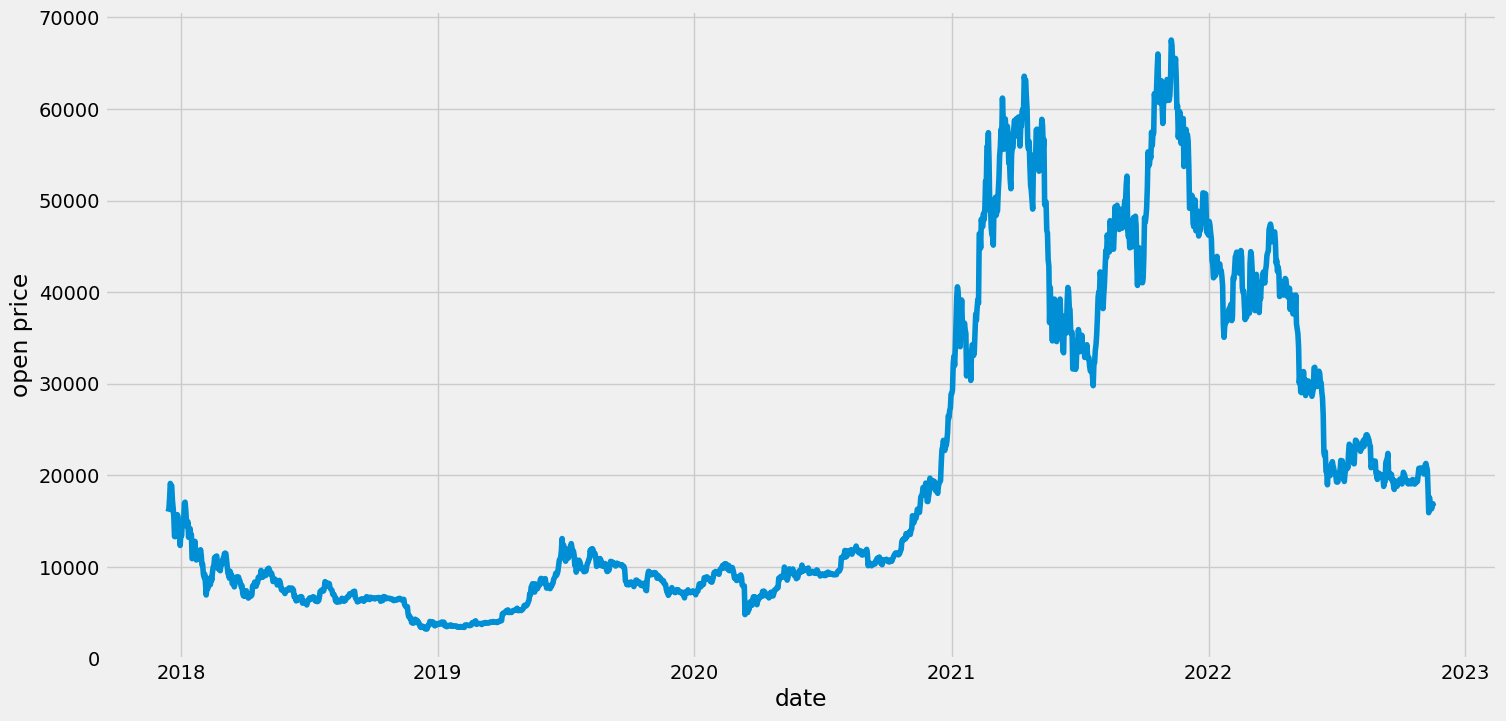

In [43]:
from pyspark.sql.functions import to_date,from_unixtime
from pyspark.sql.types import DateType,FloatType,IntegerType

from pyspark.ml import regression

selected = df.select(['open','open_time'])
# seperate data into train and test
# train_data, test_data = selected.randomSplit([0.8, 0.2])
# train_data = train_data.withColumn('close', train_data['close'].cast(IntegerType()))
# train_data = train_data.withColumn('open', train_data['open'].cast(IntegerType()))

pddf = selected.toPandas()
pddf['open_time'] = pddf['open_time'].apply(lambda time: datetime.fromtimestamp(time))
pddf['open'] = pddf['open'].apply(lambda price: float(price))
pddf = pddf.set_index('open_time')


import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
plt.plot(pddf['open'])
plt.ylabel('open price')
plt.xlabel('date')
plt.show()

In [92]:
selected = df
selected.select(['volume', 'number_of_trades', 'open']).show()

+--------------+----------------+--------------+
|        volume|number_of_trades|          open|
+--------------+----------------+--------------+
|11616.86715100|           86150|16030.34000000|
| 9181.27394700|           85478|16334.98000000|
| 4202.62870900|           51777|17516.81000000|
| 9177.18343400|           84581|19120.19000000|
|10624.63307100|           91956|18860.04000000|
|13210.74822000|          116569|18856.25000000|
|13450.49669300|          129762|17295.20000000|
|20324.21730000|          117731|16480.52000000|
|36076.27117500|          243261|15514.03000000|
|13141.53887500|          135005|13326.61000000|
|28557.53498800|          173557|13300.00000000|
|15748.20760700|          116416|13500.00000000|
|15034.66810400|          133133|13699.34000000|
|14959.86472300|          142202|15709.98000000|
|21717.85801400|          178032|15459.97000000|
|18072.00811600|          142100|14199.14000000|
|19221.15803900|          190204|14378.99000000|
|11768.98971800|    

### Question 1: How open price look like respectively to volume, number_of_trades

In [93]:
# from pyspark.ml.feature import MinMaxScaler
# import column transformer and one hot encoder
from pyspark.ml.feature import VectorAssembler,MinMaxScaler,StandardScaler

selected = selected.select(['volume', 'number_of_trades', 'open', 'open_time']) \
    .withColumn('volume', selected['volume'].cast(FloatType())) \
    .withColumn('number_of_trades', selected['number_of_trades'].cast(IntegerType())) \
    .withColumn('open', selected['open'].cast(FloatType()))

assembler = VectorAssembler(inputCols=['open','number_of_trades','volume'],outputCol='price')
output = assembler.transform(selected)

stdScaler = StandardScaler(inputCol='price',outputCol='scaled_price',withMean=True)

stdScaler = stdScaler.fit(output)
data = stdScaler.transform(output)
data.show()

+---------+----------------+--------+-----------+--------------------+--------------------+
|   volume|number_of_trades|    open|  open_time|               price|        scaled_price|
+---------+----------------+--------+-----------+--------------------+--------------------+
|11616.867|           86150|16030.34|1.5132096E9|[16030.33984375,8...|[-0.2527329087494...|
| 9181.274|           85478|16334.98| 1.513296E9|[16334.98046875,8...|[-0.2349183837384...|
| 4202.629|           51777|17516.81|1.5133824E9|[17516.810546875,...|[-0.1658082921821...|
| 9177.184|           84581|19120.19|1.5134688E9|[19120.189453125,...|[-0.0720472134439...|
|10624.633|           91956|18860.04|1.5135552E9|[18860.0390625,91...|[-0.0872600749603...|
|13210.748|          116569|18856.25|1.5136416E9|[18856.25,116569....|[-0.0874816486545...|
|13450.497|          129762| 17295.2| 1.513728E9|[17295.19921875,1...|[-0.1787674979598...|
|20324.217|          117731|16480.52|1.5138144E9|[16480.51953125,1...|[-0.226407

In [94]:
import numpy as np

train_data = data[data["open_time"] <= 1614758808]
test_data = data[data["open_time"] > 1614758808]

In [95]:
from pyspark.ml.regression import LinearRegression

regression = LinearRegression(featuresCol='scaled_price',labelCol='open')
regression = regression.fit(train_data)

pred_values = regression.evaluate(test_data)

regression.coefficients

22/11/18 11:56:07 WARN Instrumentation: [2f425870] regParam is zero, which might cause numerical instability and overfitting.


DenseVector([17100.6875, -0.0, 0.0])

In [96]:
regression.intercept

20352.246334771058

In [97]:
pred_values.predictions.show()

+---------+----------------+--------+-----------+--------------------+--------------------+------------------+
|   volume|number_of_trades|    open|  open_time|               price|        scaled_price|        prediction|
+---------+----------------+--------+-----------+--------------------+--------------------+------------------+
| 82649.72|         2291936|50349.37| 1.614816E9|[50349.37109375,2...|[1.75414729823684...| 50349.37109374999|
|  78192.5|         2054216|48374.09|1.6149024E9|[48374.08984375,2...|[1.63863841877638...| 48374.08984375001|
|44399.234|         1476474|48746.81|1.6149888E9|[48746.80859375,1...|[1.66043396063474...| 48746.80859375003|
|55235.027|         1758101| 48882.2|1.6150752E9|[48882.19921875,1...|[1.66835122273764...|48882.199218750015|
| 66987.36|         1999401|50959.11|1.6151616E9|[50959.109375,199...|[1.78980307415804...|50959.109375000015|
|71656.734|         2194398|52375.18| 1.615248E9|[52375.1796875,21...|[1.87261087433035...|     52375.1796875|
|

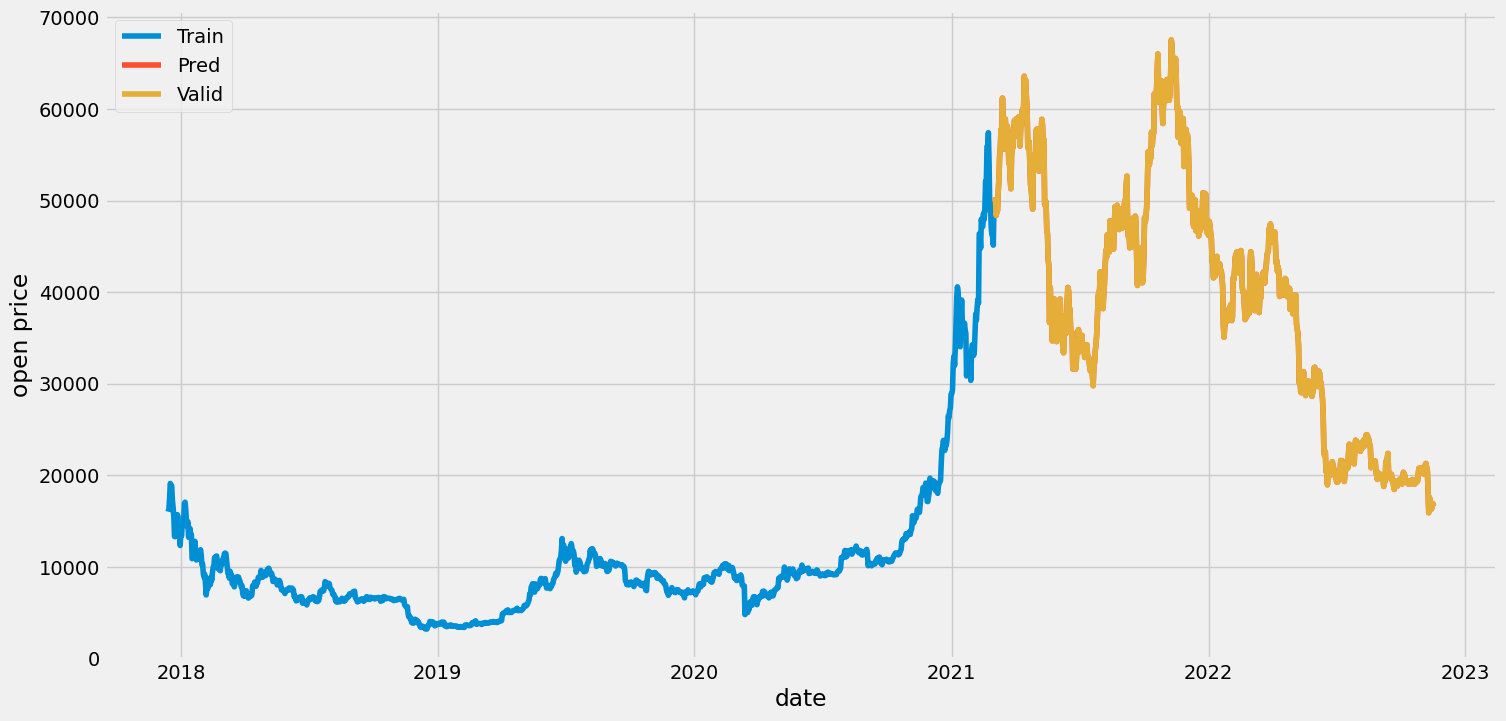

In [98]:
pddf = train_data.toPandas()
pddf['open_time'] = pddf['open_time'].apply(lambda time: datetime.fromtimestamp(time))
pddf['open'] = pddf['open'].apply(lambda price: float(price))
pddf = pddf.set_index('open_time')

plt.figure(figsize=(16,8))
plt.plot(pddf['open'])
plt.ylabel('open price')
plt.xlabel('date')

pddf = pred_values.predictions.toPandas()
pddf['open_time'] = pddf['open_time'].apply(lambda time: datetime.fromtimestamp(time))
pddf['open'] = pddf['open'].apply(lambda price: float(price))
pddf = pddf.set_index('open_time')

plt.plot(pddf['open'])


pddf = test_data.toPandas()
pddf['open_time'] = pddf['open_time'].apply(lambda time: datetime.fromtimestamp(time))
pddf['open'] = pddf['open'].apply(lambda price: float(price))
pddf = pddf.set_index('open_time')

plt.plot(pddf['open'])

# plt.plot(pddf['prediction'])
plt.legend(['Train', 'Pred', 'Valid'],loc='upper left')
plt.show()

In [99]:
pddf

,volume,number_of_trades,open,price,scaled_price
open_time,,,,,
2021-03-04,82649.718750,2291936,50349.371094,"[50349.37109375, 2291936.0, 82649.71875]","[1.7541472982368496, 0.6898053422764153, 0.189..."
2021-03-05,78192.500000,2054216,48374.089844,"[48374.08984375, 2054216.0, 78192.5]","[1.6386384187763852, 0.5364844741951545, 0.125..."
2021-03-06,44399.234375,1476474,48746.808594,"[48746.80859375, 1476474.0, 44399.234375]","[1.6604339606347434, 0.16386161971507826, -0.3..."
2021-03-07,55235.027344,1758101,48882.199219,"[48882.19921875, 1758101.0, 55235.02734375]","[1.6683512227376474, 0.3455009269467845, -0.20..."
2021-03-08,66987.359375,1999401,50959.109375,"[50959.109375, 1999401.0, 66987.359375]","[1.789803074158044, 0.5011307665396174, -0.034..."
...,...,...,...,...,...
2022-11-13,184960.781250,5382834,16813.160156,"[16813.16015625, 5382834.0, 184960.78125]","[-0.20695578353461588, 2.68332361802365, 1.649..."
2022-11-14,380210.781250,9215128,16331.780273,"[16331.7802734375, 9215128.0, 380210.78125]","[-0.23510552213942543, 5.155015704607055, 4.43..."
2022-11-15,282461.843750,7200265,16617.720703,"[16617.720703125, 7200265.0, 282461.84375]","[-0.21838453183708403, 3.8555013842940262, 3.0..."


In [100]:
pddf = train_data.toPandas()
pddf['open_time'] = pddf['open_time'].apply(lambda time: datetime.fromtimestamp(time))
pddf['open'] = pddf['open'].apply(lambda price: float(price))
pddf = pddf.set_index('open_time')

In [101]:
pddf

,volume,number_of_trades,open,price,scaled_price
open_time,,,,,
2017-12-14,11616.867188,86150,16030.339844,"[16030.33984375, 86150.0, 11616.8671875]","[-0.2527329087494507, -0.7328474606913274, -0...."
2017-12-15,9181.274414,85478,16334.980469,"[16334.98046875, 85478.0, 9181.2744140625]","[-0.23491838373845014, -0.7332808765728291, -0..."
2017-12-16,4202.628906,51777,17516.810547,"[17516.810546875, 51777.0, 4202.62890625]","[-0.16580829218217594, -0.7550168120229662, -0..."
2017-12-17,9177.183594,84581,19120.189453,"[19120.189453125, 84581.0, 9177.18359375]","[-0.07204721344390393, -0.733859409378941, -0...."
2017-12-18,10624.632812,91956,18860.039062,"[18860.0390625, 91956.0, 10624.6328125]","[-0.08726007496035675, -0.7291027990722806, -0..."
...,...,...,...,...,...
2021-02-27,66060.835938,1757720,46276.878906,"[46276.87890625, 1757720.0, 66060.8359375]","[1.5159994348935306, 0.3452551956211117, -0.04..."
2021-02-28,83055.367188,1838345,46103.671875,"[46103.671875, 1838345.0, 83055.3671875]","[1.5058707759522476, 0.39725542693968663, 0.19..."
2021-03-01,85086.109375,2147223,45134.109375,"[45134.109375, 2147223.0, 85086.109375]","[1.4491734940123282, 0.5964706511160439, 0.224..."


In [102]:
pddf = test_data.toPandas()
pddf['open_time'] = pddf['open_time'].apply(lambda time: datetime.fromtimestamp(time))
pddf['open'] = pddf['open'].apply(lambda price: float(price))
pddf = pddf.set_index('open_time')

In [103]:
pddf

,volume,number_of_trades,open,price,scaled_price
open_time,,,,,
2021-03-04,82649.718750,2291936,50349.371094,"[50349.37109375, 2291936.0, 82649.71875]","[1.7541472982368496, 0.6898053422764153, 0.189..."
2021-03-05,78192.500000,2054216,48374.089844,"[48374.08984375, 2054216.0, 78192.5]","[1.6386384187763852, 0.5364844741951545, 0.125..."
2021-03-06,44399.234375,1476474,48746.808594,"[48746.80859375, 1476474.0, 44399.234375]","[1.6604339606347434, 0.16386161971507826, -0.3..."
2021-03-07,55235.027344,1758101,48882.199219,"[48882.19921875, 1758101.0, 55235.02734375]","[1.6683512227376474, 0.3455009269467845, -0.20..."
2021-03-08,66987.359375,1999401,50959.109375,"[50959.109375, 1999401.0, 66987.359375]","[1.789803074158044, 0.5011307665396174, -0.034..."
...,...,...,...,...,...
2022-11-13,184960.781250,5382834,16813.160156,"[16813.16015625, 5382834.0, 184960.78125]","[-0.20695578353461588, 2.68332361802365, 1.649..."
2022-11-14,380210.781250,9215128,16331.780273,"[16331.7802734375, 9215128.0, 380210.78125]","[-0.23510552213942543, 5.155015704607055, 4.43..."
2022-11-15,282461.843750,7200265,16617.720703,"[16617.720703125, 7200265.0, 282461.84375]","[-0.21838453183708403, 3.8555013842940262, 3.0..."


In [104]:
pddf = pred_values.predictions.toPandas()
pddf['open_time'] = pddf['open_time'].apply(lambda time: datetime.fromtimestamp(time))
pddf['open'] = pddf['open'].apply(lambda price: float(price))
pddf = pddf.set_index('open_time')

In [105]:
pddf

,volume,number_of_trades,open,price,scaled_price,prediction
open_time,,,,,,
2021-03-04,82649.718750,2291936,50349.371094,"[50349.37109375, 2291936.0, 82649.71875]","[1.7541472982368496, 0.6898053422764153, 0.189...",50349.371094
2021-03-05,78192.500000,2054216,48374.089844,"[48374.08984375, 2054216.0, 78192.5]","[1.6386384187763852, 0.5364844741951545, 0.125...",48374.089844
2021-03-06,44399.234375,1476474,48746.808594,"[48746.80859375, 1476474.0, 44399.234375]","[1.6604339606347434, 0.16386161971507826, -0.3...",48746.808594
2021-03-07,55235.027344,1758101,48882.199219,"[48882.19921875, 1758101.0, 55235.02734375]","[1.6683512227376474, 0.3455009269467845, -0.20...",48882.199219
2021-03-08,66987.359375,1999401,50959.109375,"[50959.109375, 1999401.0, 66987.359375]","[1.789803074158044, 0.5011307665396174, -0.034...",50959.109375
...,...,...,...,...,...,...
2022-11-13,184960.781250,5382834,16813.160156,"[16813.16015625, 5382834.0, 184960.78125]","[-0.20695578353461588, 2.68332361802365, 1.649...",16813.160156
2022-11-14,380210.781250,9215128,16331.780273,"[16331.7802734375, 9215128.0, 380210.78125]","[-0.23510552213942543, 5.155015704607055, 4.43...",16331.780273
2022-11-15,282461.843750,7200265,16617.720703,"[16617.720703125, 7200265.0, 282461.84375]","[-0.21838453183708403, 3.8555013842940262, 3.0...",16617.720703


In [1]:
spark.stop()

NameError: name 'spark' is not defined